[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana10/1_Intro_NLP.ipynb)

# Problema

Vamos a revisar 4 datasets (solo 1 en clase) de oraciones financieras. Cada oración está etiquetada con un sentimiento (positivo, negativo o neutro) y se elaborarán 2 modelos para intentar clasificarlos de la mejor manera.

# Dependencias

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Carga de los datos

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Cruso-ApsFinancieras/semana10/data/sentiment_data/Sentences_AllAgree.txt',
                       sep='.@', names=['text','label'], encoding='latin1', engine='python')

Existen 4 datasets:

- Sentences_50Agree.txt
- Sentences_66Agree.txt
- Sentences_75Agree.txt
- Sentences_AllAgree.txt

Fuente: https://arxiv.org/pdf/1908.10063.pdf

In [ ]:
data

,text,label
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive
...,...,...
2259,Operating result for the 12-month period decre...,negative
2260,HELSINKI Thomson Financial - Shares in Cargote...,negative
2261,LONDON MarketWatch -- Share prices ended lower...,negative
2262,Operating profit fell to EUR 35.4 mn from EUR ...,negative


# Funciones auxiliares para procesamiento de texto

In [ ]:
def remover_stopwords(text, lang):
    stop = re.compile(r'\b(' + r'|'.join(stopwords.words(lang)) + r')\b\s*')
    nuevo_texto = stop.sub('', text)
    return nuevo_texto

In [ ]:
def elimina_puntuacion_y_numeros(text):
    nuevo_texto = re.sub('[^a-z]+', ' ', text)
    return nuevo_texto

In [ ]:
# Solo para inglés
def lematizar(text):
    lemma = WordNetLemmatizer()
    text = text.split()
    nuevo_texto = " ".join([lemma.lemmatize(i) for i in text])
    return nuevo_texto

In [ ]:
def stemmer(text, lang):
    st = SnowballStemmer(lang)
    text = text.split()
    nuevo_texto = ' '.join([st.stem(k) for k in text])
    return nuevo_texto

In [ ]:
def preprocesar(text, lang):
    text = text.lower()
    text = remover_stopwords(text, lang)
    text = elimina_puntuacion_y_numeros(text)
    text = stemmer(text, lang)
    return text

**¿Qué acción realizan las funciones?**

Veamos con un ejemplo.

In [ ]:
eg_string = 'Lemmatization is the process of converting a word to its base form. The difference between stemming and lemmatization is, ' \
            'lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the ' \
            'last few characters, often leading to incorrect meanings and spelling errors.'

In [ ]:
eg_string = eg_string.lower()
eg_string

'lemmatization is the process of converting a word to its base form. the difference between stemming and lemmatization is, lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.'

In [ ]:
remover_stopwords(eg_string, 'english')

'lemmatization process converting word base form. difference stemming lemmatization , lemmatization considers context converts word meaningful base form, whereas stemming removes last characters, often leading incorrect meanings spelling errors.'

In [ ]:
elimina_puntuacion_y_numeros(eg_string.lower())

'lemmatization is the process of converting a word to its base form the difference between stemming and lemmatization is lemmatization considers the context and converts the word to its meaningful base form whereas stemming just removes the last few characters often leading to incorrect meanings and spelling errors '

In [ ]:
stemmer(eg_string, 'english')

'lemmat is the process of convert a word to it base form. the differ between stem and lemmat is, lemmat consid the context and convert the word to it meaning base form, wherea stem just remov the last few characters, often lead to incorrect mean and spell errors.'

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
lematizar(eg_string)

'lemmatization is the process of converting a word to it base form. the difference between stemming and lemmatization is, lemmatization considers the context and convert the word to it meaningful base form, whereas stemming just remove the last few characters, often leading to incorrect meaning and spelling errors.'

¿Porque lematizar o stemizar?

In [ ]:
lematizar(remover_stopwords('my feet foot', 'english'))

'foot foot'

In [ ]:
stemmer(remover_stopwords('my feet foot', 'english'), 'english')

'feet foot'

Exploremos nuestros datos

In [ ]:
data.label.value_counts()

neutral     1391
positive     570
negative     303
Name: label, dtype: int64

In [ ]:
# Clase con menos porcentaje presente
303/data.shape[0]

0.1338339222614841

Preprocecemos nuestros datos

# Paréntesis cultural

Ejemplo de función lambda

In [ ]:
numeros = pd.DataFrame({'a':[1,2,3,4]})

In [ ]:
numeros

,a
0,1
1,2
2,3
3,4


In [ ]:
numeros['cuadrados'] = numeros['a'].apply(lambda x: x*x)
numeros

,a,cuadrados
0,1,1
1,2,4
2,3,9
3,4,16


# Fin de paréntesis cultural

# Limpieza de datos

In [ ]:
data['text_pp'] = data['text'].apply(lambda x: preprocesar(x, 'english'))

In [ ]:
data.head()

,text,label,text_pp
0,"According to Gran , the company has no plans t...",neutral,accord gran compani plan move product russia a...
1,"For the last quarter of 2010 , Componenta 's n...",positive,last quarter componenta net sale doubl eur m e...
2,"In the third quarter of 2010 , net sales incre...",positive,third quarter net sale increas eur mn oper pro...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,oper profit rose eur mn eur mn correspond peri...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,oper profit total eur mn eur mn repres net sale


**Representación gráfica para darnos una mejor idea**

In [ ]:
def nube_palabras(sec_textos):
    # Crear la cadena con la que haremos la nube de palabras
    text = " ".join(review for review in sec_textos)

    # Crear la nube de palabras
    wordcloud = WordCloud(max_font_size=50,
                          max_words=100,
                          background_color="white").generate(text)

    # Mostrar nuestro gráfico
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

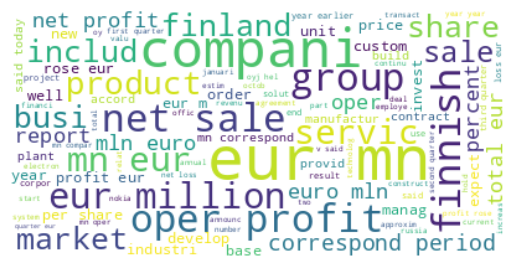

In [ ]:
nube_palabras(data['text_pp'])

Si quisieramos ver las nubes de palabras centrandonos mas en el idioma o el sentimiento a analizar

# Paréntesis Cultural: Groupby

In [ ]:
pequenio = data.loc[[0,1,2,3,2262,2263], :].copy()
pequenio

,text,label,text_pp
0,"According to Gran , the company has no plans t...",neutral,accord gran compani plan move product russia a...
1,"For the last quarter of 2010 , Componenta 's n...",positive,last quarter componenta net sale doubl eur m e...
2,"In the third quarter of 2010 , net sales incre...",positive,third quarter net sale increas eur mn oper pro...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,oper profit rose eur mn eur mn correspond peri...
2262,Operating profit fell to EUR 35.4 mn from EUR ...,negative,oper profit fell eur mn eur mn includ vessel s...
2263,Sales in Finland decreased by 10.5 % in Januar...,negative,sale finland decreas januari sale outsid finla...


In [ ]:
objeto_agrupado = pequenio.groupby('label')

In [ ]:
print(objeto_agrupado)

In [ ]:
objeto_agrupado.get_group('positive')

,text,label,text_pp
1,"For the last quarter of 2010 , Componenta 's n...",positive,last quarter componenta net sale doubl eur m e...
2,"In the third quarter of 2010 , net sales incre...",positive,third quarter net sale increas eur mn oper pro...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,oper profit rose eur mn eur mn correspond peri...


In [ ]:
for objetos in objeto_agrupado:
  print(objetos[0])
  print(objetos[1])

negative
                                                   text     label  \
2262  Operating profit fell to EUR 35.4 mn from EUR ...  negative   
2263  Sales in Finland decreased by 10.5 % in Januar...  negative   

                                                text_pp  
2262  oper profit fell eur mn eur mn includ vessel s...  
2263  sale finland decreas januari sale outsid finla...  
neutral
                                                text    label  \
0  According to Gran , the company has no plans t...  neutral   

                                             text_pp  
0  accord gran compani plan move product russia a...  
positive
                                                text     label  \
1  For the last quarter of 2010 , Componenta 's n...  positive   
2  In the third quarter of 2010 , net sales incre...  positive   
3  Operating profit rose to EUR 13.1 mn from EUR ...  positive   

                                             text_pp  
1  last quarter componenta net 

# Fin de Paréntesis Cultural

In [ ]:
porClase = data.groupby('label')
positivas = porClase.get_group('positive').text_pp
negativas = porClase.get_group('negative').text_pp
neutras = porClase.get_group('neutral').text_pp

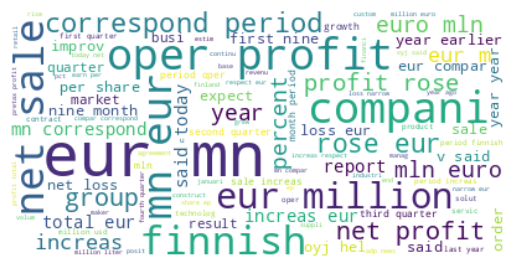

In [ ]:
nube_palabras(positivas)

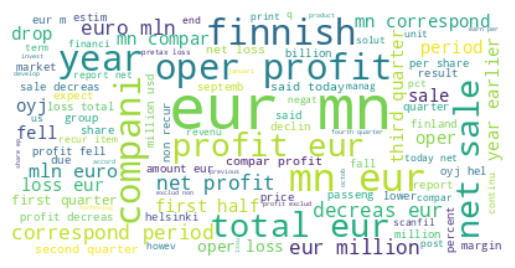

In [ ]:
nube_palabras(negativas)

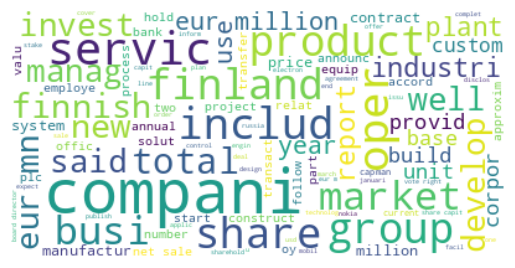

In [ ]:
nube_palabras(neutras)

Bolsa de Palabras: Nuestro modo de asignar un vector numérico a nuestras cadenas de caractéres

In [ ]:
data

,text,label,text_pp
0,"According to Gran , the company has no plans t...",neutral,accord gran compani plan move product russia a...
1,"For the last quarter of 2010 , Componenta 's n...",positive,last quarter componenta net sale doubl eur m e...
2,"In the third quarter of 2010 , net sales incre...",positive,third quarter net sale increas eur mn oper pro...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,oper profit rose eur mn eur mn correspond peri...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,oper profit total eur mn eur mn repres net sale
...,...,...,...
2259,Operating result for the 12-month period decre...,negative,oper result month period decreas profit eur tu...
2260,HELSINKI Thomson Financial - Shares in Cargote...,negative,helsinki thomson financi share cargotec fell s...
2261,LONDON MarketWatch -- Share prices ended lower...,negative,london marketwatch share price end lower londo...
2262,Operating profit fell to EUR 35.4 mn from EUR ...,negative,oper profit fell eur mn eur mn includ vessel s...


In [ ]:
# BOW: Bag Of Words
vectorizer = TfidfVectorizer(min_df=30)
BOW_en = vectorizer.fit_transform(data['text_pp'])
BOW_en.shape

(2264, 130)

In [ ]:
data.head()

,text,label,text_pp
0,"According to Gran , the company has no plans t...",neutral,accord gran compani plan move product russia a...
1,"For the last quarter of 2010 , Componenta 's n...",positive,last quarter componenta net sale doubl eur m e...
2,"In the third quarter of 2010 , net sales incre...",positive,third quarter net sale increas eur mn oper pro...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,oper profit rose eur mn eur mn correspond peri...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,oper profit total eur mn eur mn repres net sale


In [ ]:
palabras = vectorizer.get_feature_names_out()
X = pd.DataFrame(BOW_en.todense(), index=data.index, columns=palabras)
X

,accord,agreement,also,amount,announc,annual,approxim,april,area,bank,...,transact,two,unit,us,usd,use,valu,well,would,year
0,0.487236,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.247319
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2260,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.34067,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2261,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.473838,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2262,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [ ]:
data.loc[0, 'text_pp']

'accord gran compani plan move product russia although compani grow'

In [ ]:
y = data['label']
y

0        neutral
1       positive
2       positive
3       positive
4       positive
          ...   
2259    negative
2260    negative
2261    negative
2262    negative
2263    negative
Name: label, Length: 2264, dtype: object

In [ ]:
# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1811, 130) (453, 130) (1811,) (453,)


In [ ]:
X_train

,accord,agreement,also,amount,announc,annual,approxim,april,area,bank,...,transact,two,unit,us,usd,use,valu,well,would,year
316,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2161,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1894,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
427,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299228
374,0.0,0.0,0.0,0.0,0.356733,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.229581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1095,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.657693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1130,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.727477,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1294,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [ ]:
y_train

316     positive
2161    negative
1894    negative
427     positive
374     negative
          ...   
1638     neutral
1095     neutral
1130     neutral
1294     neutral
860     positive
Name: label, Length: 1811, dtype: object

# Regresión logística

In [ ]:
clasifier = LogisticRegression()
clf = clasifier.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
y_pred[:10]

array(['neutral', 'neutral', 'negative', 'neutral', 'positive', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral'], dtype=object)

In [ ]:
y_test[:10]

1755     neutral
1281     neutral
350     negative
420     positive
56      positive
1556     neutral
845     positive
1657     neutral
111     positive
2074    positive
Name: label, dtype: object

In [ ]:
# Precisión del modelo (en general)
(y_pred == y_test).sum() / y_test.shape[0]

0.8167770419426048

In [ ]:
y_test.value_counts()

neutral     276
positive    121
negative     56
Name: label, dtype: int64

In [ ]:
pd.Series(y_pred).value_counts()

neutral     311
positive    103
negative     39
dtype: int64

In [ ]:
y_train.value_counts()

neutral     1115
positive     449
negative     247
Name: label, dtype: int64

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.67      0.46      0.55        56
     neutral       0.85      0.96      0.90       276
    positive       0.78      0.66      0.71       121

    accuracy                           0.82       453
   macro avg       0.76      0.69      0.72       453
weighted avg       0.81      0.82      0.81       453



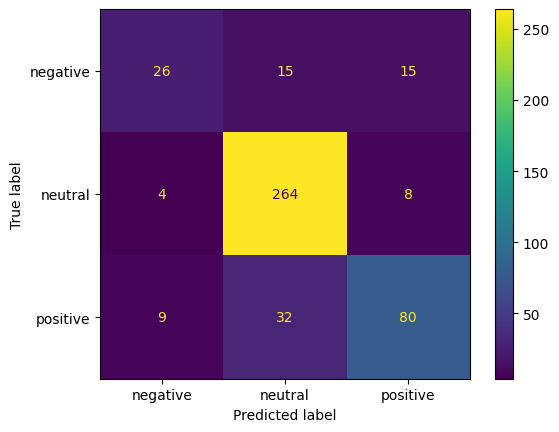

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, log_loss

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [ ]:
# Si todo se hiciera al azar, esta sería la pérdida
-np.log(1/3)

1.0986122886681098

In [ ]:
# Valor de la función de perdida
log_loss(y_test, clf.predict_proba(X_test))

0.49810643547638667

# Ejercicio:

Pruebe con alguno de los otros 3 datasets.

Muestren algunas de las oraciones a las que su algoritmo clasificó mal.